# Time Series Forecasting con Transformers de Hugging Face
# Dataset: Precio de Bitcoin en USD (BTC-USD)

Dataset acotar en prediccion - (actualmente esta en 100 dias para atras) - puede ser 365 o 720 dias - definir horizontes. comparar cuando empieza a decaer la prediccion
acotar dataset para la prediccion la fecha.
probar con 2 modelos

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 94.4M  100 94.4M    0     0  53.4M      0  0:00:01  0:00:01 --:--:-- 69.8M
Primeras filas:
       Timestamp  Open  High   Low  Close  Volume
0   1.325412e+09  4.58  4.58  4.58   4.58     0.0
1   1.325412e+09  4.58  4.58  4.58   4.58     0.0
2   1.325412e+09  4.58  4.58  4.58   4.58     0.0
3   1.325412e+09  4.58  4.58  4.58   4.58     0.0
4   1.325412e+09  4.58  4.58  4.58   4.58     0.0
5   1.325412e+09  4.58  4.58  4.58   4.58     0.0
6   1.325412e+09  4.58  4.58  4.58   4.58     0.0
7   1.325412e+09  4.58  4.58  4.58   4.58     0.0
8   1.325413e+09  4.58  4.58  4.58   4.58     0.0
9   1.325413e+09  4.58  4.58  4.58   4.58     0.0
10  1.325413e+09  4.58  4.58  4.58   4.58     0.0
11  1.325413e+09  4.58  4.58  4.58   4.58     0.0
12  1.325413e+09  

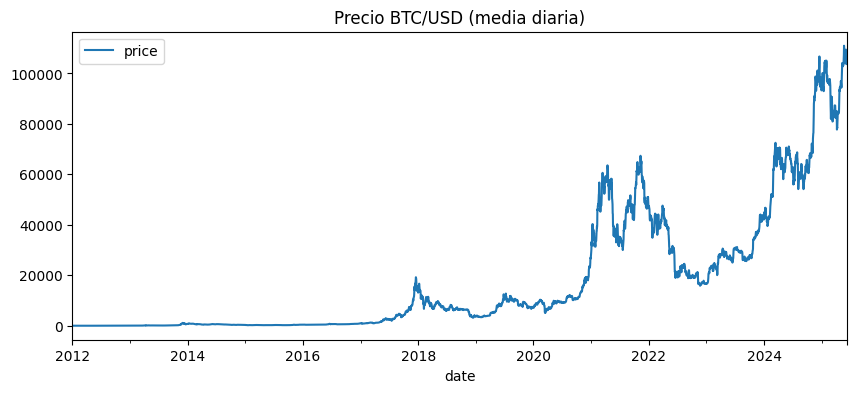

In [ ]:
# Time Series Forecasting con Transformers de Hugging Face
# Dataset: Precio de Bitcoin en USD (BTC-USD)

# Paso 1: Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from torch.utils.data import Dataset
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
    Trainer,
    TrainingArguments
)
import os
import zipfile
# Paso 1: Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from torch.utils.data import Dataset
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
    Trainer,
    TrainingArguments
)
import os
import zipfile

# Paso 1.5: Descargar y descomprimir el dataset desde Kaggle usando curl directo
zip_path = "bitcoin-historical-data.zip"
csv_filename = "btcusd_1-min_data.csv"

if not os.path.exists(csv_filename):
    if not os.path.exists(zip_path):
        !curl -L -o bitcoin-historical-data.zip \
            https://www.kaggle.com/api/v1/datasets/download/mczielinski/bitcoin-historical-data
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

# Paso 2: Cargar el CSV extraído
df = pd.read_csv(csv_filename)

print("Primeras filas:")
print(df.head(20))

# Paso 3: Preprocesamiento básico y análisis temporal
print("\nColumnas disponibles:", df.columns)
df = df.rename(columns={"Timestamp": "timestamp", "Close": "price"})
df = df.dropna(subset=['price'])
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.sort_values('date')
df = df[['date', 'price']]

# Visualizar evolución del precio (resampleado diario)
df_daily = df.set_index('date').resample('D').mean()
df_daily.plot(title="Precio BTC/USD (media diaria)", figsize=(10, 4))
plt.show()

# Paso 4: Normalización y creación de ventanas
scaler = MinMaxScaler()
df_daily['scaled_price'] = scaler.fit_transform(df_daily[['price']])
df_daily = df_daily.dropna()

def create_sequences(df, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(df) - window_size - forecast_horizon):
        X.append(df['scaled_price'].iloc[i:i+window_size].values)
        y.append(df['scaled_price'].iloc[i+window_size:i+window_size+forecast_horizon].values)
    return np.array(X), np.array(y)



In [ ]:
df_daily.head(10)

,price,scaled_price
date,,
2012-01-01,4.645697,0.000003
2012-01-02,4.975000,0.000006
2012-01-03,5.085500,0.000007
2012-01-04,5.170396,0.000008
2012-01-05,5.954361,0.000015
2012-01-06,6.620333,0.000021
2012-01-07,6.047778,0.000016
2012-01-08,6.819444,0.000023
2012-01-09,6.816451,0.000023


### Descomposición aditiva: tendencia, estacionalidad y residuo

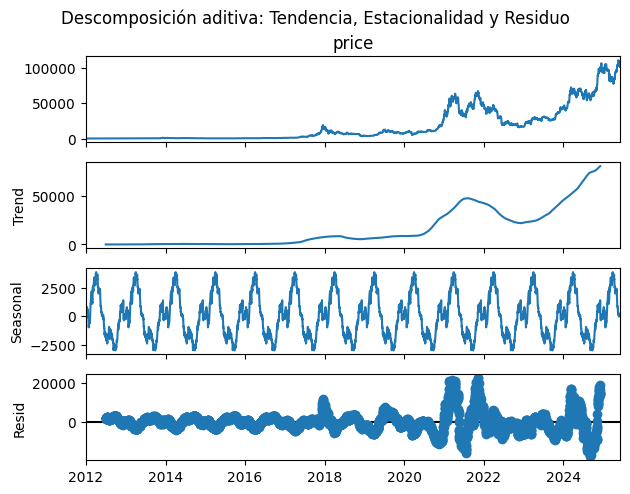

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_daily['price'], model='additive', period=365)
result.plot()
plt.suptitle("Descomposición aditiva: Tendencia, Estacionalidad y Residuo", y=1.02)
plt.show()


### Deteccion o cambio de regimen

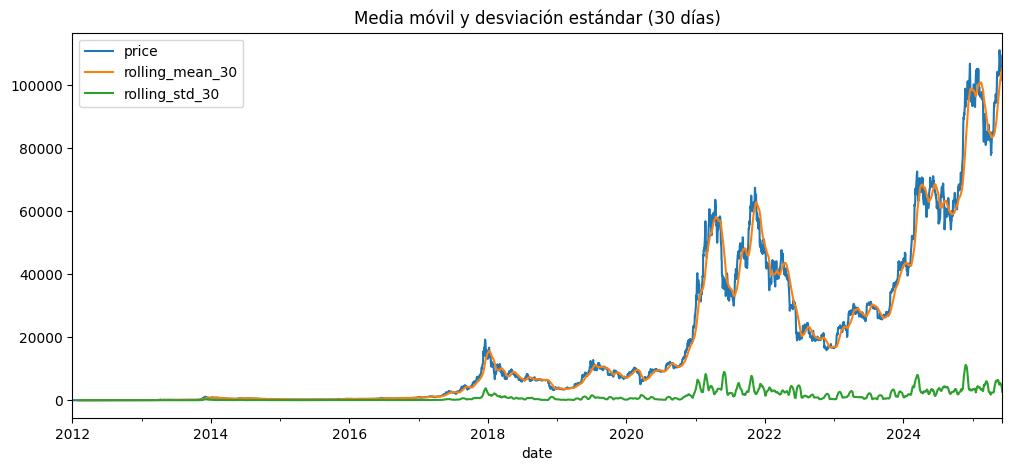

In [ ]:
df_daily['rolling_mean_30'] = df_daily['price'].rolling(window=30).mean()
df_daily['rolling_std_30'] = df_daily['price'].rolling(window=30).std()

df_daily[['price', 'rolling_mean_30', 'rolling_std_30']].plot(figsize=(12, 5))
plt.title("Media móvil y desviación estándar (30 días)")
plt.show()


### Autocorrelación

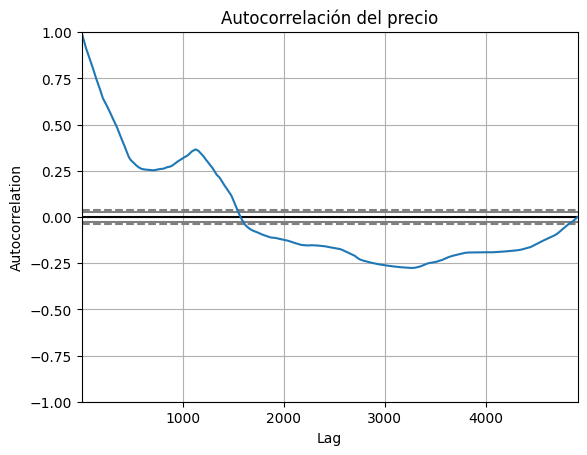

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_daily['price'].dropna())
plt.title("Autocorrelación del precio")
plt.show()

### Histogramas y distribución

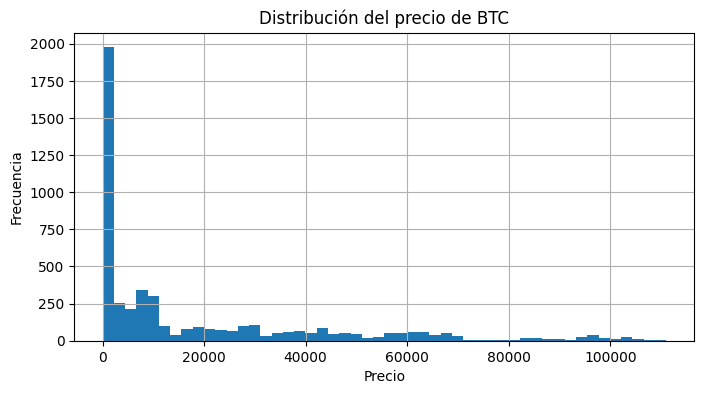

In [ ]:
df_daily['price'].hist(bins=50, figsize=(8, 4))
plt.title("Distribución del precio de BTC")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()


### Análisis de volatilidad

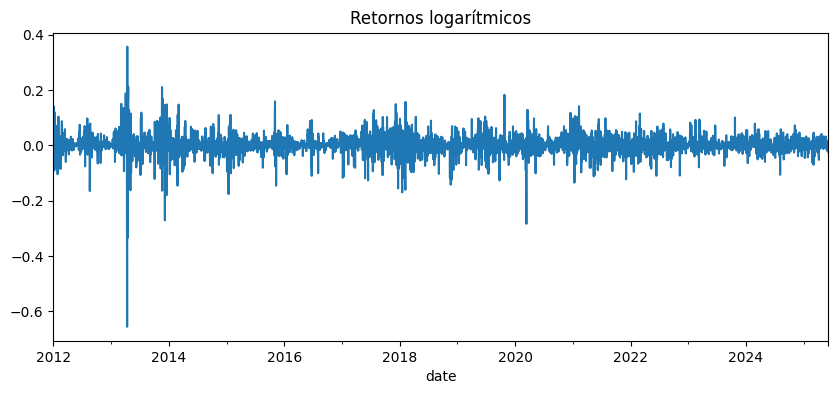

In [ ]:
df_daily['log_return'] = np.log(df_daily['price'] / df_daily['price'].shift(1))
df_daily['log_return'].plot(figsize=(10, 4), title="Retornos logarítmicos")
plt.show()


# Predicciones

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 19.8 K | train
-------------------------------------------------------------
17.8 K    Trainab

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

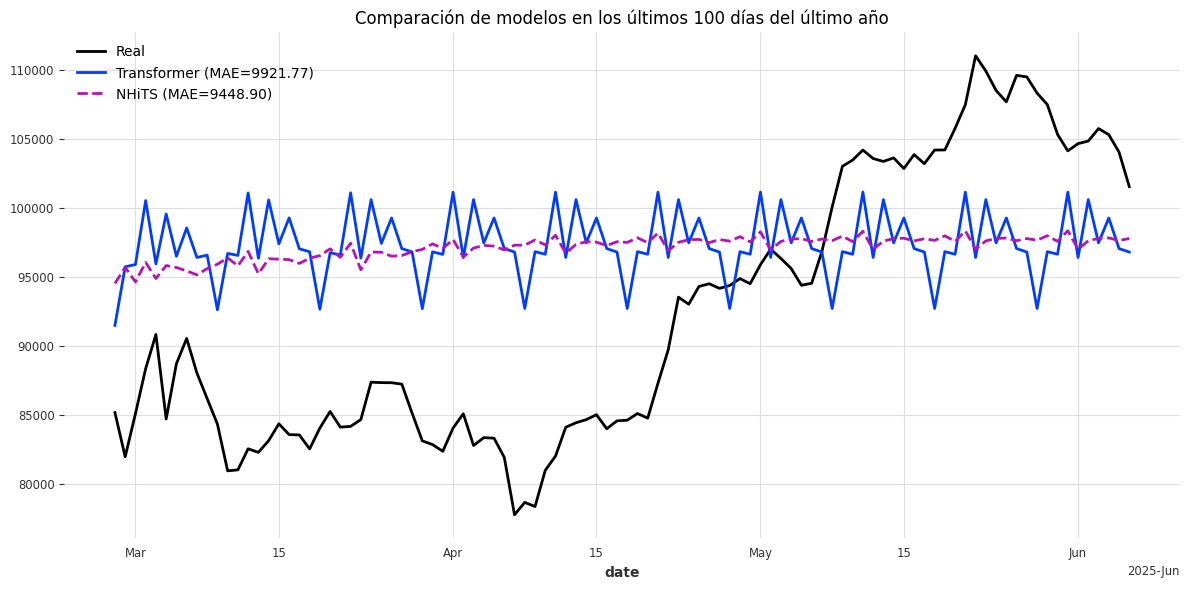

((np.float64(9921.772496355674), np.float64(11019.931499442453)),
 (np.float64(9448.901641465534), np.float64(10440.692146324955)))

In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from darts.models import TransformerModel, NHiTSModel

# Convertir la serie original completa
series = TimeSeries.from_dataframe(df_daily.reset_index(), time_col='date', value_cols='price')

# Recortar al último año y preparar últimos 100 días para test
series_last_year = series.slice(series.time_index[-365], series.time_index[-1])
series_train = series_last_year[:-100]
series_test = series_last_year[-100:]

# Escalado
scaler = Scaler()
series_train_scaled = scaler.fit_transform(series_train)
series_test_scaled = scaler.transform(series_test)

# TransformerModel
transformer = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=10,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=20,
    random_state=42
)
transformer.fit(series_train_scaled)

# NHiTSModel
nhits = NHiTSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    n_epochs=20,
    random_state=42,
    batch_size=32,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    dropout=0.1
)
nhits.fit(series_train_scaled)

# predicciones
forecast_transformer = transformer.predict(n=100)
forecast_nhits = nhits.predict(n=100)


series_test_back = scaler.inverse_transform(series_test_scaled)
forecast_transformer_back = scaler.inverse_transform(forecast_transformer)
forecast_nhits_back = scaler.inverse_transform(forecast_nhits)

mae_transformer = mae(series_test_back, forecast_transformer_back)
rmse_transformer = rmse(series_test_back, forecast_transformer_back)

mae_nhits = mae(series_test_back, forecast_nhits_back)
rmse_nhits = rmse(series_test_back, forecast_nhits_back)

plt.figure(figsize=(12, 6))
series_test_back.plot(label="Real")
forecast_transformer_back.plot(label=f"Transformer (MAE={mae_transformer:.2f})")
forecast_nhits_back.plot(label=f"NHiTS (MAE={mae_nhits:.2f})", linestyle='--')
plt.title("Comparación de modelos en los últimos 100 días del último año")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(mae_transformer, rmse_transformer), (mae_nhits, rmse_nhits)


## Predicción a 10 días con los dos modelos entrenados (Transformers y NHiTS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

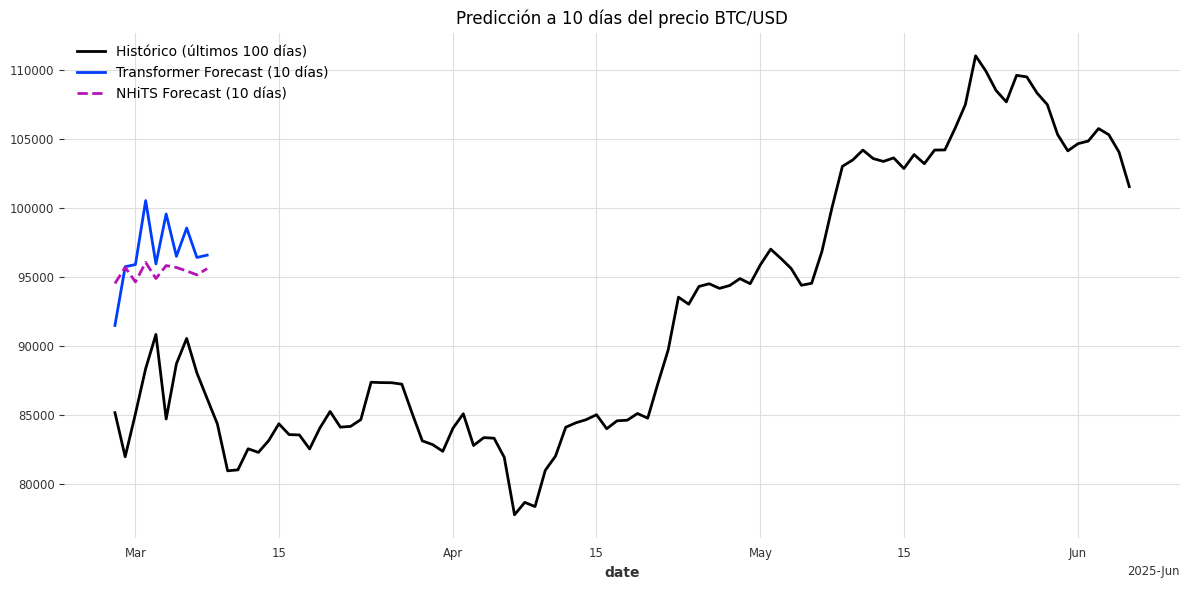

In [ ]:

# Predicción a 10 días
forecast_transformer_10 = transformer.predict(n=10)
forecast_nhits_10 = nhits.predict(n=10)

series_full_scaled = scaler.transform(series)
series_full_back = scaler.inverse_transform(series_full_scaled)
forecast_transformer_10_back = scaler.inverse_transform(forecast_transformer_10)
forecast_nhits_10_back = scaler.inverse_transform(forecast_nhits_10)

plt.figure(figsize=(12, 6))
series_full_back[-100:].plot(label="Histórico (últimos 100 días)")
forecast_transformer_10_back.plot(label="Transformer Forecast (10 días)")
forecast_nhits_10_back.plot(label="NHiTS Forecast (10 días)", linestyle='--')
plt.title("Predicción a 10 días del precio BTC/USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip freeze > requirements.txt

## Tomando desde el 6/06/2025 predicción a 5 días.

In [ ]:
df = pd.read_csv("btcusd_1-min_data.csv")
df = df.rename(columns={"Timestamp": "timestamp", "Close": "price"})
df = df.dropna(subset=["price"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.sort_values("date")
df = df[["date", "price"]]

df_daily = df.set_index("date").resample("D").mean().dropna().reset_index()


In [ ]:
df_daily

,date,price
0,2012-01-01,4.645697
1,2012-01-02,4.975000
2,2012-01-03,5.085500
3,2012-01-04,5.170396
4,2012-01-05,5.954361
...,...,...
4901,2025-06-02,104833.055556
4902,2025-06-03,105737.187500
4903,2025-06-04,105295.186111
4904,2025-06-05,104032.127778


In [ ]:
series = TimeSeries.from_dataframe(df_daily, time_col='date', value_cols='price')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 21.0 K | train
-------------------------------------------------------------
19.1 K    Trainab

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

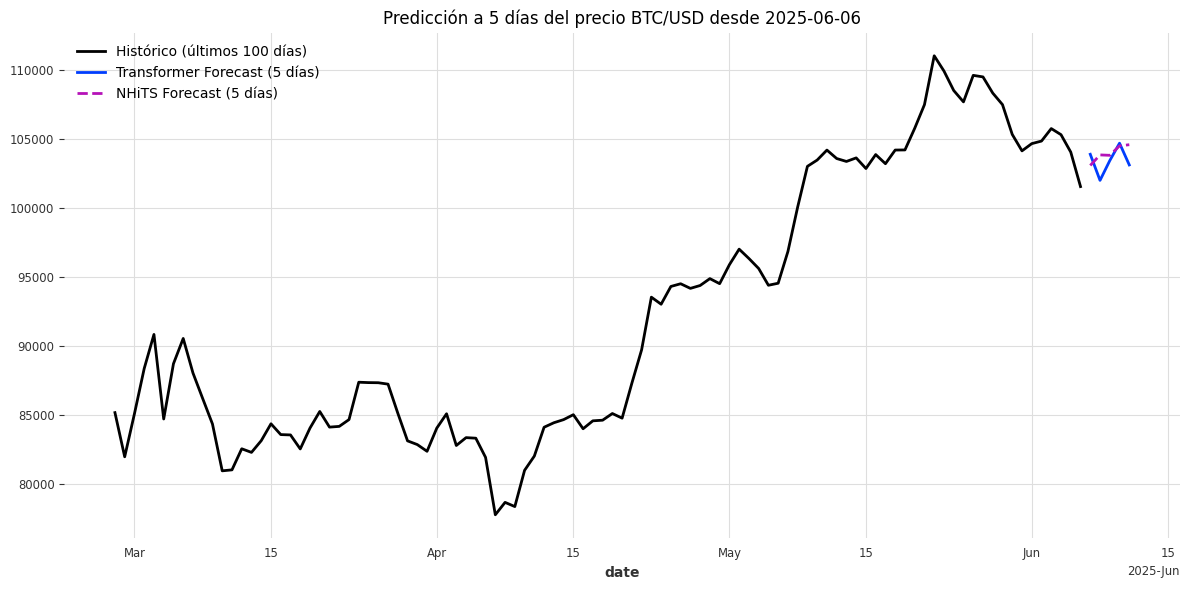

In [ ]:
today = series.time_index[-1]
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

transformer = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=5,
    d_model=64,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=20,
    random_state=42
)
transformer.fit(series_scaled)

nhits = NHiTSModel(
    input_chunk_length=30,
    output_chunk_length=5,
    n_epochs=20,
    random_state=42,
    batch_size=32,
    num_blocks=1,
    num_layers=2,
    layer_widths=64,
    dropout=0.1
)
nhits.fit(series_scaled)

forecast_transformer_5 = transformer.predict(n=5)
forecast_nhits_5 = nhits.predict(n=5)

series_back = scaler.inverse_transform(series_scaled)
forecast_transformer_5_back = scaler.inverse_transform(forecast_transformer_5)
forecast_nhits_5_back = scaler.inverse_transform(forecast_nhits_5)

plt.figure(figsize=(12, 6))
series_back[-100:].plot(label="Histórico (últimos 100 días)")
forecast_transformer_5_back.plot(label="Transformer Forecast (5 días)")
forecast_nhits_5_back.plot(label="NHiTS Forecast (5 días)", linestyle='--')
plt.title(f"Predicción a 5 días del precio BTC/USD desde {today.date()}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## De 6/06/2025 a 20 días

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

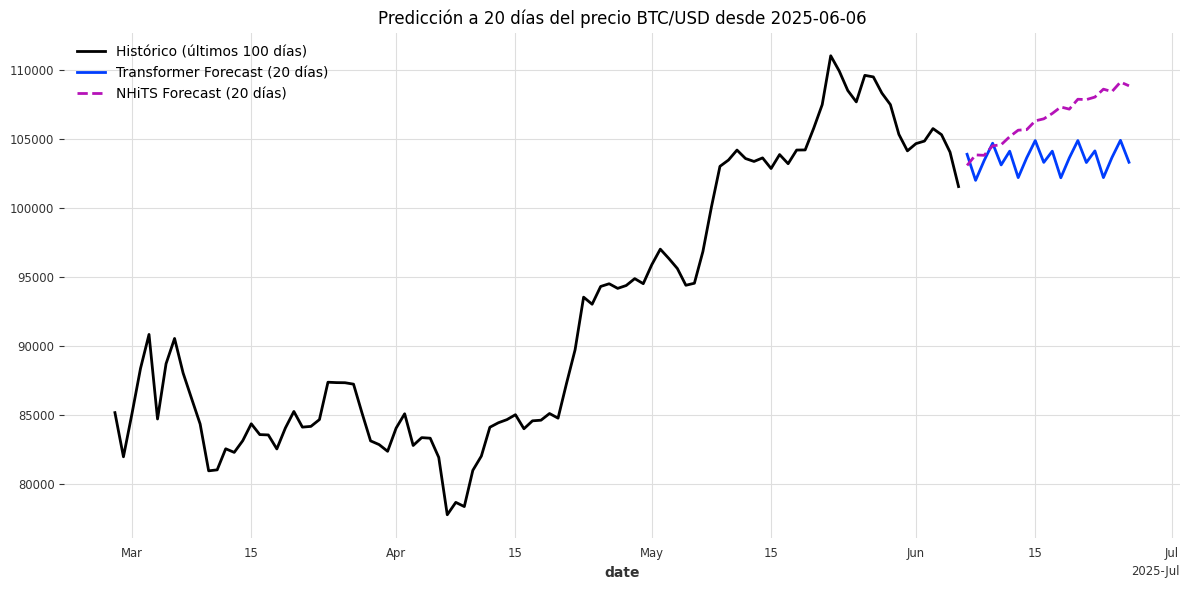

In [ ]:
forecast_transformer_5 = transformer.predict(n=20)
forecast_nhits_5 = nhits.predict(n=20)

series_back = scaler.inverse_transform(series_scaled)
forecast_transformer_5_back = scaler.inverse_transform(forecast_transformer_5)
forecast_nhits_5_back = scaler.inverse_transform(forecast_nhits_5)

plt.figure(figsize=(12, 6))
series_back[-100:].plot(label="Histórico (últimos 100 días)") # -> probar a un año y dos
forecast_transformer_5_back.plot(label="Transformer Forecast (20 días)")
forecast_nhits_5_back.plot(label="NHiTS Forecast (20 días)", linestyle='--')
plt.title(f"Predicción a 20 días del precio BTC/USD desde {today.date()}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()